# Observações importantes
* Todas as análises, estatísticas e afirmações feitas nos comentários (markdowns) foram coletadas com o dataset completo, que é composto por 4 milhões de linhas. Porém, para agilizar o processo de desenvolvimento, foi coletada uma amostra aleatória de 50 mil registros;
* O conjunto de dados (data) é a junção de todos os anos (2009, 2010, 2011 e 2012);
* Este notebook foi construídos no Sagemaker, por isso o caminho de leitura do dado aponta para o S3. Mas o arquivo .parquet será disponibilizado para download.

# Instalando dependencias

In [35]:
!pip install folium

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Importações

In [36]:
import pyarrow.parquet as pq
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# Para tomar os dias da semana
from datetime import datetime
# Para o mapa
import folium

# Carregando os dados

In [37]:
data = pq.read_table("s3://dadosfera-dev/datalake/refined/nyctaxy/nyctaxi-trips.parquet").to_pandas()

# Análise Exploratória de Dados

In [38]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000000 entries, 0 to 3999999
Data columns (total 14 columns):
 #   Column                Dtype  
---  ------                -----  
 0   dt_dropoff            object 
 1   nr_dropoff_latitude   float64
 2   nr_dropoff_longitude  float64
 3   vl_fare_amount        float64
 4   qt_passenger          int64  
 5   dt_pickup             object 
 6   nr_pickup_latitude    float64
 7   nr_pickup_longitude   float64
 8   cd_vendor             object 
 9   nm_vendor_name        object 
 10  vl_tip                float64
 11  vl_total              float64
 12  nr_trip_distance      float64
 13  nm_payment_type       object 
dtypes: float64(8), int64(1), object(5)
memory usage: 427.2+ MB


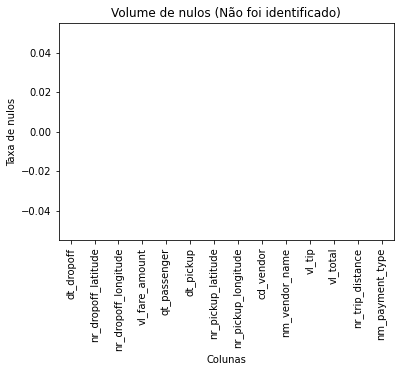

In [39]:
data.isna().sum().plot.bar()
plt.title('Volume de nulos (Não foi identificado)')
plt.xlabel('Colunas')
plt.ylabel('Taxa de nulos')
plt.show()

In [40]:
data.describe()

,nr_dropoff_latitude,nr_dropoff_longitude,vl_fare_amount,qt_passenger,nr_pickup_latitude,nr_pickup_longitude,vl_tip,vl_total,nr_trip_distance
count,4.000000e+06,4.000000e+06,4.000000e+06,4.000000e+06,4.000000e+06,4.000000e+06,4.000000e+06,4.000000e+06,4.000000e+06
mean,4.013500e+01,-7.284804e+01,9.629421e+00,1.733573e+00,4.012473e+01,-7.283060e+01,4.085400e-01,1.032687e+01,2.678209e+00
std,4.986513e+00,9.050543e+00,7.567478e+00,1.254536e+00,5.026362e+00,9.122395e+00,1.258632e+00,8.503208e+00,3.130601e+00
min,-1.520200e-02,-7.919139e+01,2.500000e+00,0.000000e+00,-9.262000e-03,-8.487835e+01,0.000000e+00,2.500000e+00,0.000000e+00
25%,4.073537e+01,-7.399067e+01,5.400000e+00,1.000000e+00,4.073639e+01,-7.399112e+01,0.000000e+00,5.700000e+00,1.000000e+00
50%,4.075449e+01,-7.397953e+01,7.300000e+00,1.000000e+00,4.075453e+01,-7.398111e+01,0.000000e+00,7.800000e+00,1.700000e+00
75%,4.076952e+01,-7.396339e+01,1.090000e+01,2.000000e+00,4.076844e+01,-7.396681e+01,0.000000e+00,1.140000e+01,3.000000e+00
max,4.793581e+01,8.668000e-03,2.000000e+02,6.000000e+00,4.792285e+01,4.023000e-03,9.823000e+01,2.300000e+02,4.992000e+01


### Limpeza de dados

**Obs**: estas limpezas foram algumas inconsistências encontradas durante a análise, mas todos os pontos levantados aqui deveriam ser discutidos tanto com o time que fornece os dados quanto com o time de negócios. Dependendo do retorno, estas tratativas poderiam entrar nos pipelines de engenharia construídos no Glue, caso necessário.

In [41]:
def remove_outliers(column):
    # função para remover os outliers, tomando apenas valores entre o quantil 2% e 98%
    return data[data[column].between(data[column].quantile(0.02), data[column].quantile(0.98))]

In [42]:
# Existem latitudes e longitudes iguais a 0, o que faz com que as coordenadas caiam no meio do Oceano Atlântico, levando
# suspeitas em relação a qualidade dos dados. Optou-se então, para esta análise, remover estes outliers. Mas seria necessário
# uma investigação com o fornecedor dos dados e com o time de negócios para verificar se existe alguma regra de negócio 
# envolvida como, por exemplo, o destino não ser fornecido pelo cliente.
data = remove_outliers('nr_dropoff_latitude')
data = remove_outliers('nr_dropoff_longitude')
data = remove_outliers('nr_pickup_latitude')
data = remove_outliers('nr_pickup_longitude')

# Distância não deve ser negativa nem zerada
data = data.query('nr_trip_distance > 0.0')

# Nesta limpeza cabe a dúvida: serviços de delivery são considerados como "viagens sem passageiros"? Novamente, seria necessário
# verificar com os fornecedores dos dados e com o time de negócios.
data = data.query('qt_passenger > 0')

In [43]:
# IMPORTANTE
# Aqui é tomada a amostra de 50 mil registros explicada em "Observações importantes". Caso queira chegar nas estatísticas reais,
# basta remover/comentar a linha abaixo
# data = data.sample(50000)

In [44]:
# Após limpeza
data.describe()

,nr_dropoff_latitude,nr_dropoff_longitude,vl_fare_amount,qt_passenger,nr_pickup_latitude,nr_pickup_longitude,vl_tip,vl_total,nr_trip_distance
count,3.374432e+06,3.374432e+06,3.374432e+06,3.374432e+06,3.374432e+06,3.374432e+06,3.374432e+06,3.374432e+06,3.374432e+06
mean,4.075355e+01,-7.397768e+01,8.095686e+00,1.737774e+00,4.075372e+01,-7.398010e+01,3.194831e-01,8.606002e+00,2.032851e+00
std,2.325866e-02,1.985858e-02,4.134807e+00,1.256679e+00,1.943747e-02,1.584488e-02,8.708337e-01,4.541968e+00,1.683774e+00
min,4.063908e+01,-7.401121e+01,2.500000e+00,1.000000e+00,4.069571e+01,-7.400933e+01,0.000000e+00,2.500000e+00,1.000000e-02
25%,4.073929e+01,-7.399061e+01,5.300000e+00,1.000000e+00,4.073966e+01,-7.399111e+01,0.000000e+00,5.700000e+00,9.600000e-01
50%,4.075556e+01,-7.398049e+01,7.000000e+00,1.000000e+00,4.075534e+01,-7.398196e+01,0.000000e+00,7.400000e+00,1.540000e+00
75%,4.076903e+01,-7.396786e+01,9.700000e+00,2.000000e+00,4.076725e+01,-7.397085e+01,0.000000e+00,1.020000e+01,2.560000e+00
max,4.081275e+01,-7.386767e+01,1.555000e+02,6.000000e+00,4.079749e+01,-7.391138e+01,9.823000e+01,2.169000e+02,4.970000e+01


## Número de passageiros

In [45]:
data.groupby('qt_passenger').size()

qt_passenger
1    2178376
2     618652
3     176336
4      99476
5     288144
6      13448
dtype: int64

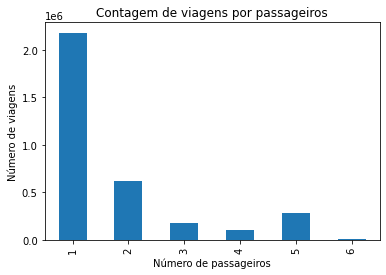

In [46]:
data.qt_passenger.value_counts().sort_index().plot.bar()
plt.title('Contagem de viagens por passageiros')
plt.xlabel('Número de passageiros')
plt.ylabel('Número de viagens')
plt.show()

### Qual a distância média percorrida por viagens com no máximo 2 passageiros?

A distância percorrida em viagens com até 2 passageiros é, em média, 2.02km (célula abaixo). 

Obs: não é especificado a unidade de medida (se é milhas ou quilômetro), assumirei quilômetros.

In [47]:
data.query('qt_passenger > 0 and qt_passenger <= 2').nr_trip_distance.mean()

2.024365161878967

In [48]:
df_temp_number_passengers = data.qt_passenger.value_counts(normalize = True).to_frame()
df_temp_number_passengers['qt_passenger_cumsum'] = df_temp_number_passengers.qt_passenger.cumsum()
df_temp_number_passengers

,qt_passenger,qt_passenger_cumsum
1,0.645553,0.645553
2,0.183335,0.828889
5,0.085390,0.914279
3,0.052256,0.966535
4,0.029479,0.996015
6,0.003985,1.000000


Viagens com 1 passageiro representam 64.55% das viagens. Já viagens com 2 passageiros, 18.33%. Interessante observar que há um valor considerável de viagens com 5 passageiros (8,53%), até mesmo maior que com 3 pessoas (5,22%). Algum evento pode estar enviesando os dados. Talvez uma possível explicação é que jovens costumam ir ou retornar juntos de eventos e festas, chamando um mesmo táxi, ou até mesmo famílias indo para o aeroporto para iniciar uma viagem em família e por isso contratam um mesmo veículo... Resumindo, pode ser uma informação interessante ou mero acaso, mas se faz necessário uma investigação mais profunda para compreender este fenômeno.

### Quais os 3 maiores vendors em quantidade total de dinheiro arrecadado?
Visualizando o gráfico acima, tem-se que **Creative Mobile Technologies, LLC** é o fornecedor que mais arrecadou, com um somatório, nos 4 anos, de 13950565.36 dólares, seguido pela **VeriFone Inc** (13356427.32 dólares), uma diferença de, aproximadamente, 2,58%. A terceira posição fica com a **Dependable Driver Service, Inc**, registrando um somatório de 1733328.68 dólares.

In [49]:
data.groupby(['cd_vendor', 'nm_vendor_name']).vl_total.sum().sort_values(ascending = False).to_frame()

,,vl_total
cd_vendor,nm_vendor_name,
CMT,"Creative Mobile Technologies, LLC",13950565.36
VTS,VeriFone Inc,13356427.32
DDS,"Dependable Driver Service, Inc",1733328.68
TS,Total Solutions Co,45.60


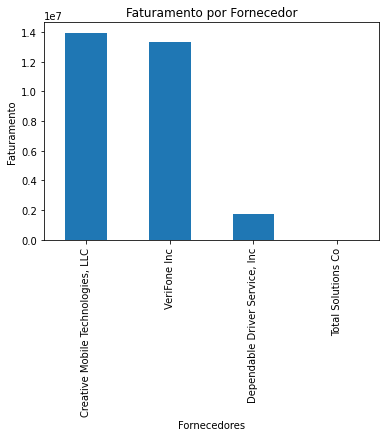

In [50]:
data.groupby('nm_vendor_name').vl_total.sum().sort_values(ascending = False).plot.bar()
plt.title('Faturamento por Fornecedor')
plt.xlabel('Fornecedores')
plt.ylabel('Faturamento')
plt.show()

## Faturamento por mês

In [51]:
# selecionando apenas pagamentos em dinheiro
# filtrando apenas as colunas que interessam para não duplicar o dataframe (pode causar problemas de memória)
df_datetime_in_cash = data.query("nm_payment_type == 'Cash'").copy()[['dt_pickup', 'vl_total']]

# colocando dt_pickup como índice para utilizar o resample
df_datetime_index = df_datetime_in_cash.set_index(df_datetime_in_cash.dt_pickup.astype('datetime64')).drop('dt_pickup', axis = 1)
df_datetime_index.head(10)

,vl_total
dt_pickup,
2009-04-21 18:51:11,5.40
2009-01-13 07:40:07,15.40
2009-01-06 19:30:44,7.10
2009-09-24 08:28:09,13.40
2009-10-29 05:50:39,8.20
2009-10-23 17:14:45,6.50
2009-03-30 09:41:23,26.25
2009-03-30 13:21:23,6.10
2009-02-20 18:06:37,3.70


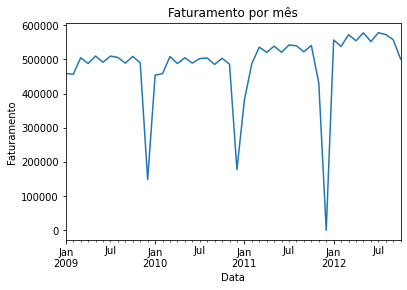

In [52]:
df_datetime_index.resample('m').vl_total.sum().plot()
plt.title('Faturamento por mês')
plt.xlabel('Data')
plt.ylabel('Faturamento')
plt.show()

### Faça um histograma da distribuição mensal, nos 4 anos, de corridas pagas em dinheiro.

In [53]:
# reaproveitando df_datetime_in_cash anterior
df_month_vl_total = df_datetime_in_cash.copy()
# tomando o ano de dt_pickup
df_month_vl_total['dt_year'] = df_month_vl_total['dt_pickup'].astype('datetime64').apply(lambda date: date.year)
# tomando o mês de dt_pickup
df_month_vl_total['dt_month'] = df_month_vl_total['dt_pickup'].astype('datetime64').apply(lambda date: date.month)
df_month_vl_total.head(10)

,dt_pickup,vl_total,dt_year,dt_month
0,2009-04-21 18:51:11,5.40,2009,4
1,2009-01-13 07:40:07,15.40,2009,1
2,2009-01-06 19:30:44,7.10,2009,1
3,2009-09-24 08:28:09,13.40,2009,9
4,2009-10-29 05:50:39,8.20,2009,10
5,2009-10-23 17:14:45,6.50,2009,10
6,2009-03-30 09:41:23,26.25,2009,3
8,2009-03-30 13:21:23,6.10,2009,3
9,2009-02-20 18:06:37,3.70,2009,2
12,2009-02-10 04:47:00,9.30,2009,2


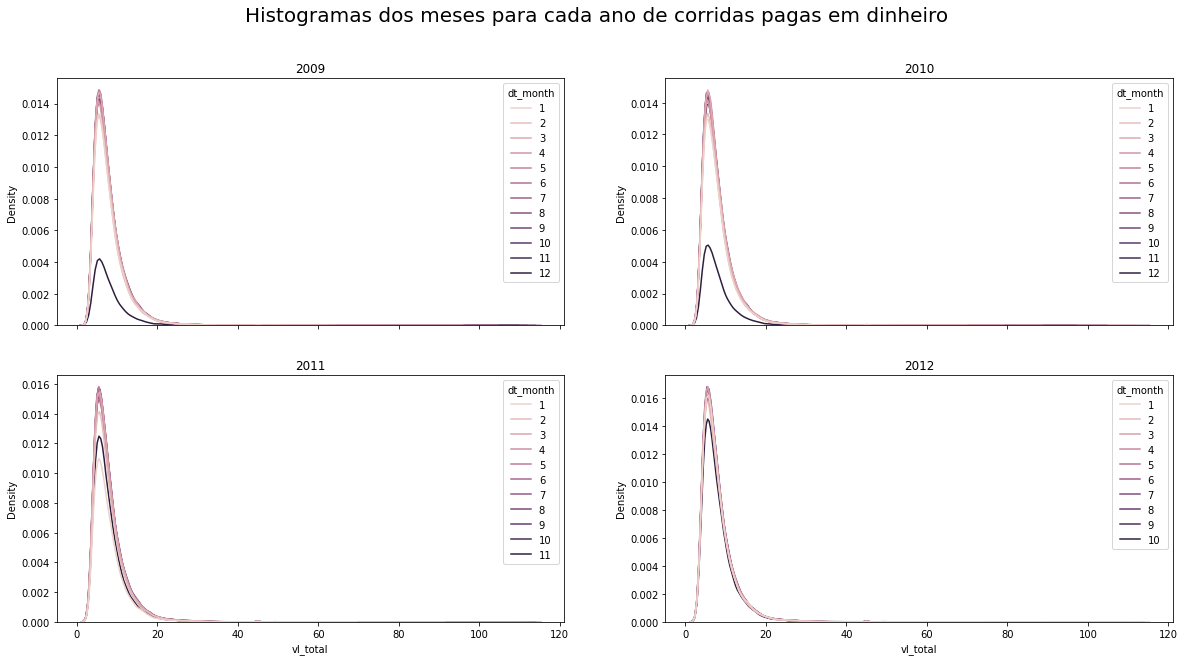

In [54]:
fig, ax = plt.subplots(2, 2, figsize = (20, 10), sharex = True)

sns.kdeplot(data = df_month_vl_total.query('dt_year == 2009'), hue = 'dt_month', x = 'vl_total', ax = ax[0, 0])
sns.kdeplot(data = df_month_vl_total.query('dt_year == 2010'), hue = 'dt_month', x = 'vl_total', ax = ax[0, 1])
sns.kdeplot(data = df_month_vl_total.query('dt_year == 2011'), hue = 'dt_month', x = 'vl_total', ax = ax[1, 0])
sns.kdeplot(data = df_month_vl_total.query('dt_year == 2012'), hue = 'dt_month', x = 'vl_total', ax = ax[1, 1])

plt.suptitle("Histogramas dos meses para cada ano de corridas pagas em dinheiro", fontsize = 20)

ax[0, 0].title.set_text('2009')
ax[0, 1].title.set_text('2010')
ax[1, 0].title.set_text('2011')
ax[1, 1].title.set_text('2012')

Para melhorar a visualização, será feito um filtro de vl_total menor que 30.

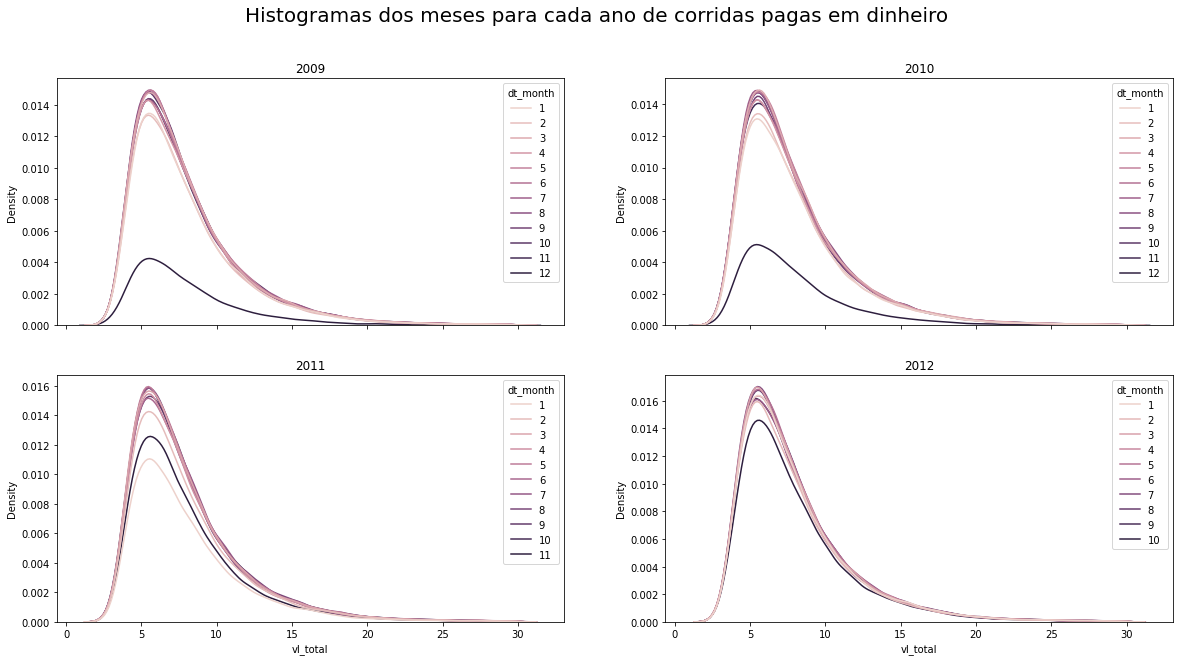

In [55]:
fig, ax = plt.subplots(2, 2, figsize = (20, 10), sharex = True)

sns.kdeplot(data = df_month_vl_total.query('dt_year == 2009').query('vl_total <= 30'), hue = 'dt_month', x = 'vl_total', ax = ax[0, 0])
sns.kdeplot(data = df_month_vl_total.query('dt_year == 2010').query('vl_total <= 30'), hue = 'dt_month', x = 'vl_total', ax = ax[0, 1])
sns.kdeplot(data = df_month_vl_total.query('dt_year == 2011').query('vl_total <= 30'), hue = 'dt_month', x = 'vl_total', ax = ax[1, 0])
sns.kdeplot(data = df_month_vl_total.query('dt_year == 2012').query('vl_total <= 30'), hue = 'dt_month', x = 'vl_total', ax = ax[1, 1])

plt.suptitle("Histogramas dos meses para cada ano de corridas pagas em dinheiro", fontsize = 20)
    
ax[0, 0].title.set_text('2009')
ax[0, 1].title.set_text('2010')
ax[1, 0].title.set_text('2011')
ax[1, 1].title.set_text('2012')

### Faça um gráfico de série temporal contando a quantidade de gorjetas de cada dia, nos últimos 3 meses de 2011.

In [56]:
df_last_three_months_2011 = data.query("dt_pickup >= '2011-09-01 00:00:00' and dt_pickup <= '2011-12-31 23:59:59'")
df_last_three_months_2011 = df_last_three_months_2011.copy()[['dt_pickup', 'vl_tip']]

df_last_three_months_2011_indexed = df_last_three_months_2011.set_index(df_last_three_months_2011.dt_pickup.astype('datetime64')).drop('dt_pickup', axis = 1)
df_last_three_months_2011_indexed.head(10)

,vl_tip
dt_pickup,
2011-09-21 23:37:38,0.00
2011-11-15 18:57:56,0.00
2011-10-02 19:47:30,0.00
2011-09-07 19:37:25,2.00
2011-10-07 09:47:52,0.00
2011-10-14 19:22:22,5.24
2011-11-12 21:37:30,0.00
2011-10-05 12:51:43,0.00
2011-10-15 14:44:26,0.00


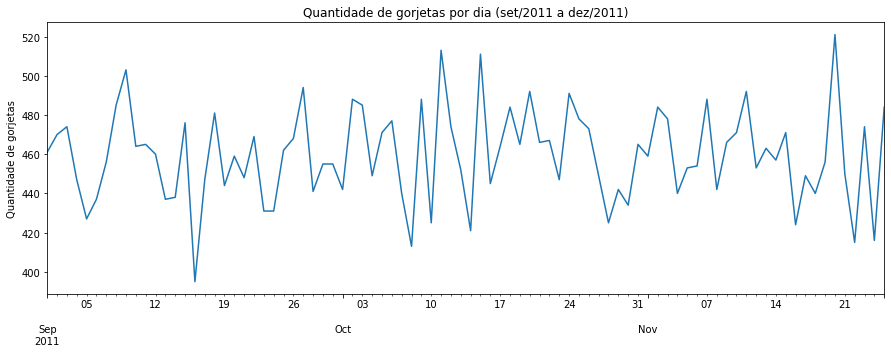

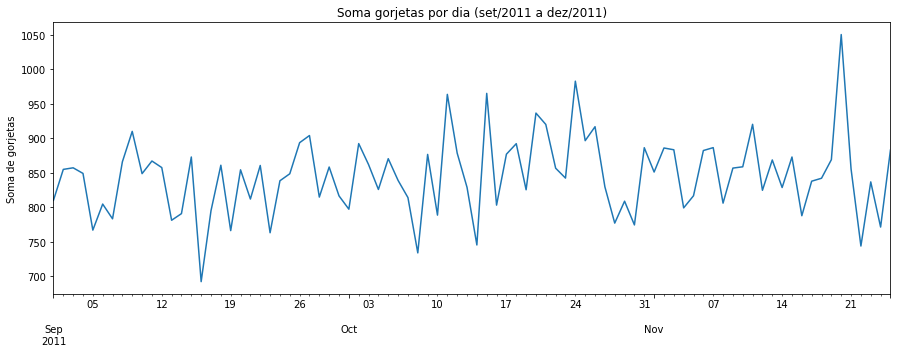

In [57]:
plt.figure(figsize = (15, 5))

# para pegar a quantidade, só foi transformados valores maiores que 0 (há gorjetas)
df_last_three_months_2011_indexed.vl_tip.apply(lambda x: 1 if (x > 0) else 0).resample('d').sum().plot()
plt.title('Quantidade de gorjetas por dia (set/2011 a dez/2011)')
plt.xlabel('')
plt.ylabel('Quantidade de gorjetas')

plt.figure(figsize = (15, 5))
df_last_three_months_2011_indexed.resample('d').vl_tip.sum().plot()
plt.title('Soma gorjetas por dia (set/2011 a dez/2011)')
plt.xlabel('')
plt.ylabel('Soma de gorjetas')
plt.show()

### Qual o tempo médio das corridas nos dias de semana.

In [58]:
# tomando o nome dos dias da semana baseado na dt_pickup
data['nm_weekday'] = data.dt_pickup.astype('datetime64').apply(lambda date: date.strftime('%A'))

In [59]:
# tomando a duração da viagem através da diferença entre desembarque e embarque
data['dt_trip_duration'] = data.dt_dropoff.astype('datetime64') - data.dt_pickup.astype('datetime64')

In [60]:
data.query("nm_weekday in ('Monday', 'Tuesday', 'Wednesday', 'Thuesday', 'Friday')").dt_trip_duration.mean()

Timedelta('0 days 00:08:44.900675431')

In [61]:
data.groupby('nm_weekday').dt_trip_duration.mean()

nm_weekday
Friday      0 days 00:08:44.944973316
Monday      0 days 00:08:44.786621789
Saturday    0 days 00:08:44.938372093
Sunday      0 days 00:08:44.688292361
Thursday    0 days 00:08:44.779120548
Tuesday     0 days 00:08:45.003874563
Wednesday   0 days 00:08:44.867459227
Name: dt_trip_duration, dtype: timedelta64[ns]

Pelo que é possível constatar acima, o tempo médio de viagem é de aproximadamente 8 minutos e 45 segundos. Descendo a um nível dia a dia, podemos constatar o mesmo padrão de tempo em todos os dias da semana. 

Uma possibilidade que explica esse evento seja o alto volume de viagens rotineiras como as corridas para o trabalho. Caberia uma investigação mais profunda: será que a grande maioria das viagens têm como destino o trabalho das pessoas?

### Fazer uma visualização em mapa com latitude e longitude de pickups and dropoffs no ano de 2010.

In [62]:
# Tomando apenas as coordenadas, neste caso vou ignorar as labels nos marcadores do mapa
# Além disso, peguei apenas uma amostra aleatória de 150 registros para uma melhor visualização
df_coordinates = data[['nr_pickup_latitude', 
                       'nr_pickup_longitude', 
                       'nr_dropoff_latitude', 
                       'nr_dropoff_longitude']].head(150)

df_coordinates.head(10)

,nr_pickup_latitude,nr_pickup_longitude,nr_dropoff_latitude,nr_dropoff_longitude
0,40.742950,-74.004114,40.747950,-73.994712
1,40.747784,-73.996506,40.792385,-73.940449
2,40.752070,-73.951340,40.768108,-73.944535
3,40.729128,-74.001117,40.721812,-73.958122
4,40.756873,-73.976600,40.776075,-73.979757
5,40.750528,-73.994665,40.750478,-73.978623
6,40.772843,-73.955462,40.774042,-73.870838
7,40.757998,-73.976158,40.759317,-73.985112
8,40.764408,-73.988585,40.761585,-73.975072
9,40.740683,-74.001978,40.747330,-73.993722


Abaixo tem-se um mapa interativo com os pickups (em azul) e dropoffs (em verde). É possível perceber, com a imagem abaixo, onde se encontram a maioria de viagens, tanto o início como o fim.

In [63]:
map_new = folium.Map(location = [40.760912, -73.980867], zoom_start = 12)

df_pickup_coord = df_coordinates.values.tolist()

for i in df_pickup_coord:
    map_new.add_child(folium.Marker(location = [i[0], i[1]], icon = folium.Icon(color = 'blue')))
    map_new.add_child(folium.Marker(location = [i[2], i[3]], icon = folium.Icon(color = 'green')))

map_new